## Early Predictor for Student Success Based on Behavioural and Demographical Indicators

Import libraries

In [1]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Load data

In [2]:
zf = zipfile.ZipFile('./data.zip')
student_info = pd.read_csv(zf.open('studentInfo.csv'))
student_vle = pd.read_csv(zf.open('studentVle.csv'))
student_assessment = pd.read_csv(zf.open('studentAssessment.csv'))
student_registration = pd.read_csv(zf.open('studentRegistration.csv'))
assessments = pd.read_csv(zf.open('assessments.csv'))

Basic information about modules, first assessments and number of registered students

In [3]:
# Get information about first day assessments
basic_info = assessments.filter(items=['code_module', 'code_presentation', 'date'])
basic_info = basic_info.groupby(['code_module', 'code_presentation']).min()
basic_info = pd.merge(basic_info, assessments, on=['code_module', 'code_presentation', 'date'],
                             how='inner').filter(items=['code_module', 'code_presentation', 'id_assessment', 'date'])

# Get total number of registered students for each module
registrations = student_registration.filter(items=['code_module', 'code_presentation', 'id_student']).groupby(
    ['code_module', 'code_presentation']).count().reset_index()
basic_info.insert(4, "number of registered students", registrations['id_student'])
basic_info

,code_module,code_presentation,id_assessment,date,number of registered students
0,AAA,2013J,1752,19.0,383
1,AAA,2014J,1758,19.0,365
2,BBB,2013B,14984,19.0,1767
3,BBB,2013J,14996,19.0,2237
4,BBB,2014B,15008,12.0,1613
5,BBB,2014J,15020,19.0,2292
6,CCC,2014B,24286,18.0,1936
7,CCC,2014J,24295,18.0,2498
8,DDD,2013B,25341,23.0,1303
9,DDD,2013J,25348,25.0,1938


### Data preparation

In [4]:
clicks_before_start = student_vle[student_vle['date'] < 0]

# Merge student_info and student_registration tables to get registration_date
df1 = pd.merge(student_info, student_registration, how='left', on=['id_student', 'code_module', 'code_presentation'])

# Merge previous table with basic_info that was created earlier to get first assessment days and ids
df2 = pd.merge(df1, basic_info, on=['code_module', 'code_presentation'], how='left')

# Merge previous table with student assessment to find student's scores on their first assessments
df3 = pd.merge(df2, student_assessment, on=['id_assessment', 'id_student'], how='left')

# Merge previous table with clicks_before_start table that was created earlier
data = pd.merge(df3, clicks_before_start, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Keep only columns that are needed later
data = data.filter(['code_module', 'code_presentation', 'id_student', 'score', 'highest_education', 'sum_click',
                    'date_registration', 'age_band',
                    'disability', 'gender', 'num_of_prev_attempts', 'final_result'])
data.fillna(value=0, inplace=True)

# Get number of clicks before course start
data = data.groupby(
    ['code_module', 'code_presentation', 'id_student', 'score', 'highest_education', 'date_registration',
     'age_band', 'disability', 'gender', 'num_of_prev_attempts', 'final_result']).sum().reset_index()

# Get the final dataframe that will be used
data = data[['id_student', 'gender', 'highest_education', 'age_band', 'num_of_prev_attempts', 'disability', 'score',
             'date_registration', 'sum_click', 'final_result']]
data.rename(columns={'score': 'first_assignment', 'sum_click': 'clicks_before_start',
                     'num_of_prev_attempts': 'previous_attempts', 'age_band': 'age'}, inplace=True)
data.head()

,id_student,gender,highest_education,age,previous_attempts,disability,first_assignment,date_registration,clicks_before_start,final_result
0,11391,M,HE Qualification,55<=,0,N,78.0,-159.0,98.0,Pass
1,28400,F,HE Qualification,35-55,0,N,70.0,-53.0,215.0,Pass
2,30268,F,A Level or Equivalent,35-55,0,Y,0.0,-92.0,102.0,Withdrawn
3,31604,F,A Level or Equivalent,35-55,0,N,72.0,-52.0,169.0,Pass
4,32885,F,Lower Than A Level,0-35,0,N,69.0,-176.0,295.0,Pass


Number of students in 4 categories based on their final results.

<AxesSubplot:>

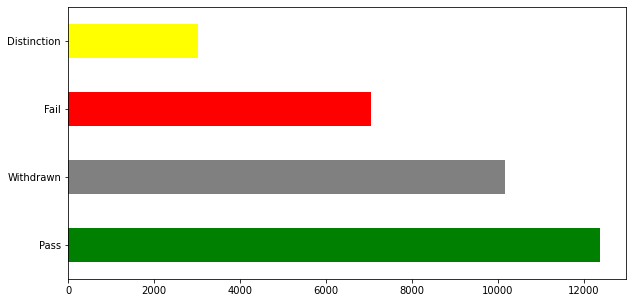

In [5]:
counts = student_info['final_result'].value_counts()
counts.plot.barh(x=['Pass', 'Withdrawn', 'Fail', 'Distinction'], color=['green', 'gray', 'red', 'yellow'],
                 figsize=(10, 5))

Converting all categorical variables into dichotomous variables.

In [6]:
education_mapping = {
    'No Formal quals': 0,
    'Lower Than A Level': 0,
    'A Level or Equivalent': 0,
    'HE Qualification': 1,
    'Post Graduate Qualification': 1
}

age_mapping = {
    '0-35': 0,
    '35-55': 1,
    '55<=': 1
}

grade_mapping = {
    'Withdrawn': 0,
    'Fail': 1,
    'Pass': 2,
    'Distinction': 3
}

gender_mapping = {
    'F': 1,
    'M': 0
}

disability_mapping = {
    'N': 0,
    'Y': 1
}

data['highest_education'] = data['highest_education'].map(education_mapping)
data['age'] = data['age'].map(age_mapping)
data['final_result'] = data['final_result'].map(grade_mapping)
data['gender'] = data['gender'].map(gender_mapping)
data['disability'] = data['disability'].map(disability_mapping)

data.head()

,id_student,gender,highest_education,age,previous_attempts,disability,first_assignment,date_registration,clicks_before_start,final_result
0,11391,0,1,1,0,0,78.0,-159.0,98.0,2
1,28400,1,1,1,0,0,70.0,-53.0,215.0,2
2,30268,1,0,1,0,1,0.0,-92.0,102.0,0
3,31604,1,0,1,0,0,72.0,-52.0,169.0,2
4,32885,1,0,0,0,0,69.0,-176.0,295.0,2


Pearson's correlation matrix for input variables.

Text(0.5, 1.0, "Pearson's correlation matrix for input variables")

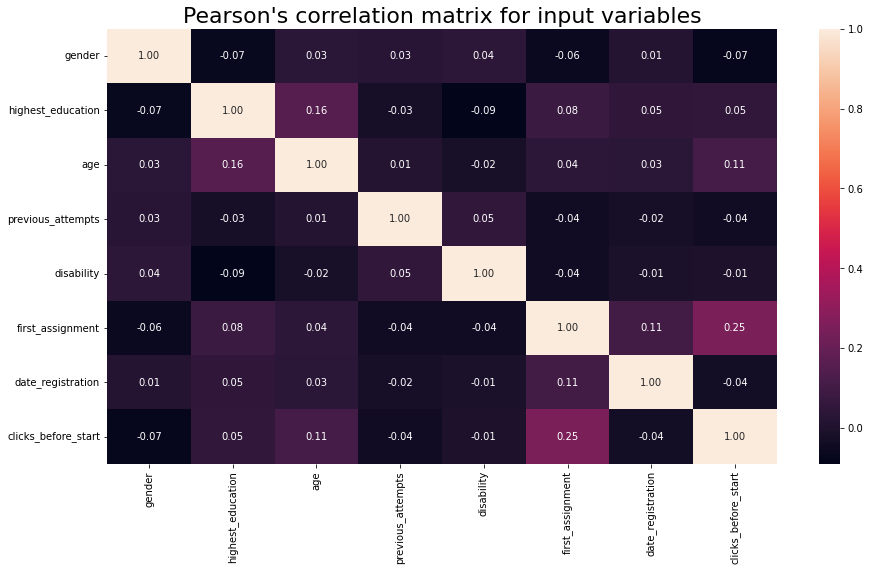

In [7]:
plt.figure(figsize=(15, 8))
corr = data.drop(columns=['id_student', 'final_result'], inplace=False).corr(method='pearson')
corr_heatmap = sns.heatmap(corr, annot=True, fmt='.2f')
corr_heatmap.set_title('Pearson\'s correlation matrix for input variables', fontdict={'fontsize': 22})

Pearson chi-square test - testing whether the output was dependent upon the categorical input variables
(Educational level, Age, Gender and Disability).

In [8]:
from scipy.stats import chi2_contingency

test_df = pd.DataFrame(index=['statistic', 'p-value'])

for var in ['highest_education', 'age', 'gender', 'disability']:
    obs = pd.crosstab(data[var], data['final_result'])
    chi2, pval, _, __ = chi2_contingency(obs)
    test_df.insert(0, var, [chi2, pval])
test_df

,disability,gender,age,highest_education
statistic,1.384540e+02,16.530150,2.068228e+02,3.829559e+02
p-value,8.143196e-30,0.000883,1.415187e-44,1.088496e-82


Initialize lambdas that will be later used for one-vs-rest models.

In [9]:
withdrawn_lambda = lambda x: 1 if x == 0 else -1
fail_lambda = lambda x: 1 if x == 1 else -1
pass_lambda = lambda x: 1 if x == 2 else -1
distinction_lambda = lambda x: 1 if x == 3 else -1

Generate training and testing sets.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['first_assignment', 'highest_education', 'age', 'gender', 'previous_attempts', 'disability', 'clicks_before_start', 'date_registration']],
                                                    data['final_result'], test_size=0.3, random_state=2)

y_train_withdrawn = y_train.map(withdrawn_lambda)
y_test_withdrawn = y_test.map(withdrawn_lambda)

y_train_fail = y_train.map(fail_lambda)
y_test_fail = y_test.map(fail_lambda)

y_train_pass = y_train.map(pass_lambda)
y_test_pass = y_test.map(pass_lambda)

y_train_distinction = y_train.map(distinction_lambda)
y_test_distinction = y_test.map(distinction_lambda)

y_trains = [y_train_withdrawn, y_train_fail, y_train_pass, y_train_distinction]
y_tests = [y_test_withdrawn, y_test_fail, y_test_pass, y_test_distinction]

### Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier

decision_trees = [DecisionTreeClassifier(class_weight='balanced', min_samples_split=10) for i in range(4)]

for index, tree in enumerate(decision_trees):
    tree.fit(X_train, y_trains[index])

### Random Forest

In [12]:
from sklearn.ensemble import RandomForestClassifier

random_forests = [RandomForestClassifier(n_jobs=-1, class_weight='balanced', bootstrap=False, min_samples_split=10) for i in range(4)]

for index, forest in (enumerate(random_forests)):
    forest.fit(X_train, y_trains[index])

### Bayesian Additive Regression Trees (BART)


In [13]:
from bartpy.sklearnmodel import SklearnModel

barts = [SklearnModel(n_burn=200, n_chains=2, n_samples=200, n_trees=50, alpha=0.9, beta=1.5) for i in range(4)]

for index, bart in enumerate(barts):
    bart.fit(X_train, y_trains[index])

### Results


In [14]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix

results = []

for model, test in zip(decision_trees + random_forests, y_tests * 2):
    for score in [precision_score, recall_score, f1_score, accuracy_score]:
        results.append(score(y_pred=model.predict(X_test), y_true=test))

for model, test in zip(barts, y_tests):
    for score in [precision_score, recall_score, f1_score, accuracy_score]:
        results.append(score(y_pred=[1 if res >= 0 else -1 for res in model.predict(X_test)], y_true=test))

split = np.array_split(results, 3)

multi = pd.MultiIndex.from_product(
    [['Withdrawn', 'Fail', 'Pass', 'Distinction'], ['Precision', 'Recall', 'F1', 'Accuracy']],
    names=['Final result', 'Metric'])

results = pd.DataFrame(index=multi, columns=['Decision tree', 'Random forest', 'BART'],
                       data={'Decision tree': split[0], 'Random forest': split[1], 'BART': split[2]})
results

c:\users\korisnik\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision tree  Random forest      BART
Final result Metric                                           
Withdrawn    Precision       0.496376       0.657609  0.761803
             Recall          0.664881       0.607633  0.594242
             F1              0.568403       0.631634  0.667670
             Accuracy        0.691552       0.783494  0.819288
Fail         Precision       0.254514       0.285840  0.227273
             Recall          0.414414       0.309151  0.002371
             F1              0.315353       0.297039  0.004693
             Accuracy        0.611884       0.684394  0.783084
Pass         Precision       0.514238       0.529677  0.564051
             Recall          0.571014       0.649012  0.592885
             F1              0.541141       0.583304  0.578109
             Accuracy        0.624156       0.640110  0.664144
Distinction  Precision       0.186869       0.252345  0.000000
             Recall          0.375423       0.303269  0.000000
             F1              0.249532       0.275474  0.000000
             Accuracy        0.795152       0.855287  0.909286

Confusion matrix for Pass-vs-rest.

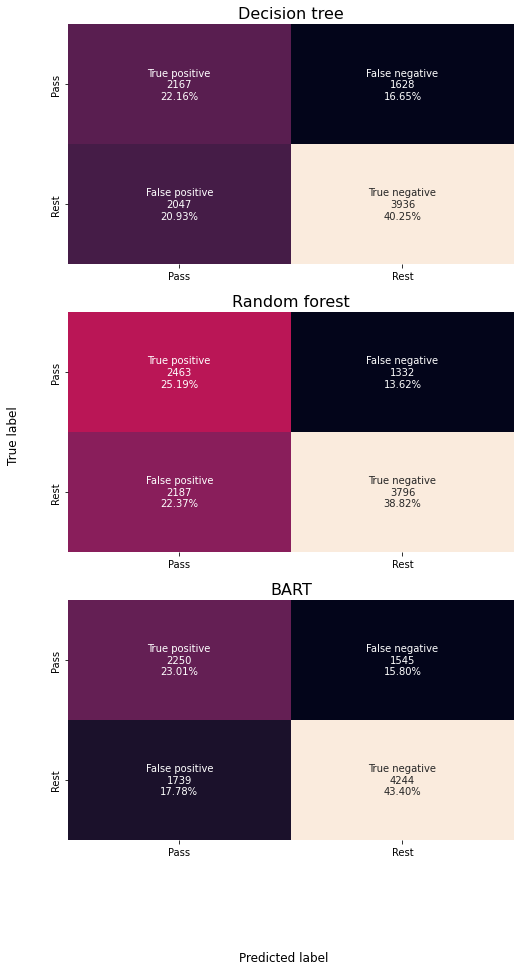

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(8, 15))
fig.supxlabel('Predicted label')
fig.supylabel('True label')
k = 1
titles = ['Decision tree', 'Random forest', 'BART']

for index, model in enumerate([decision_trees[2], random_forests[2], barts[2]]):
    cf_matrix = confusion_matrix(y_true=y_tests[2], y_pred=model.predict(X_test) if index != 2 else
    [1 if res >= 0 else -1 for res in model.predict(X_test)], labels=[1, -1])
    group_names = ['True positive', 'False negative', 'False positive', 'True negative']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.subplot(3, 1, k)
    plt.title(titles[index], fontdict={'fontsize': 16})
    df_cm = pd.DataFrame(cf_matrix, columns=['Pass', 'Rest'], index=['Pass', 'Rest'])
    sns.heatmap(df_cm, annot=labels, fmt='', cbar=False)
    k += 1

Performance of the algorithms for the Distinction-vs-rest classification task.

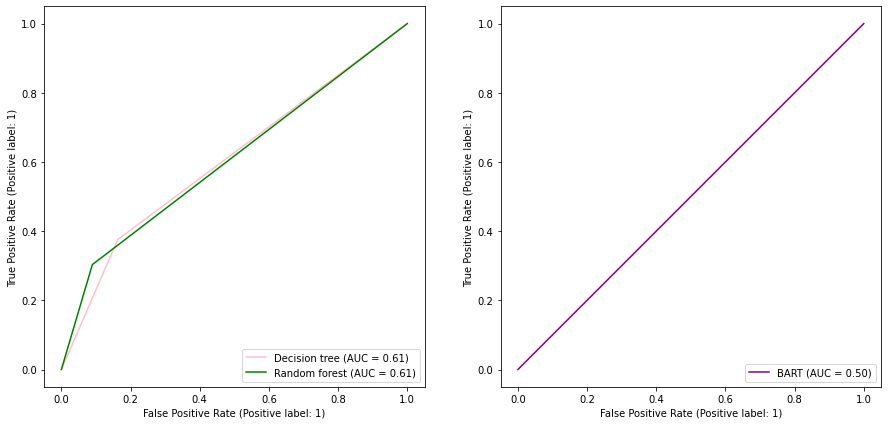

In [16]:
from sklearn.metrics import RocCurveDisplay

fig, axs = plt.subplots(1, 2, figsize=(15,7))

decision_tree_roc = RocCurveDisplay.from_predictions(y_true=y_tests[3], y_pred=decision_trees[3].predict(X_test), name='Decision tree')
random_forest_roc = RocCurveDisplay.from_predictions(y_true=y_tests[3], y_pred=random_forests[3].predict(X_test), name='Random forest')
bart_roc = RocCurveDisplay.from_predictions(y_true=y_tests[3], y_pred=[1 if res >= 0 else -1 for res in barts[3].predict(X_test)], name='BART')

decision_tree_roc.plot(ax=axs[0], color='pink')
random_forest_roc.plot(ax=axs[0], color='green')
bart_roc.plot(ax=axs[1], color='purple')

for _ in range(3):
    plt.close()

Relationship between the number of clicks and the overall student outcome.

<AxesSubplot:xlabel='Clicks', ylabel='Average score'>

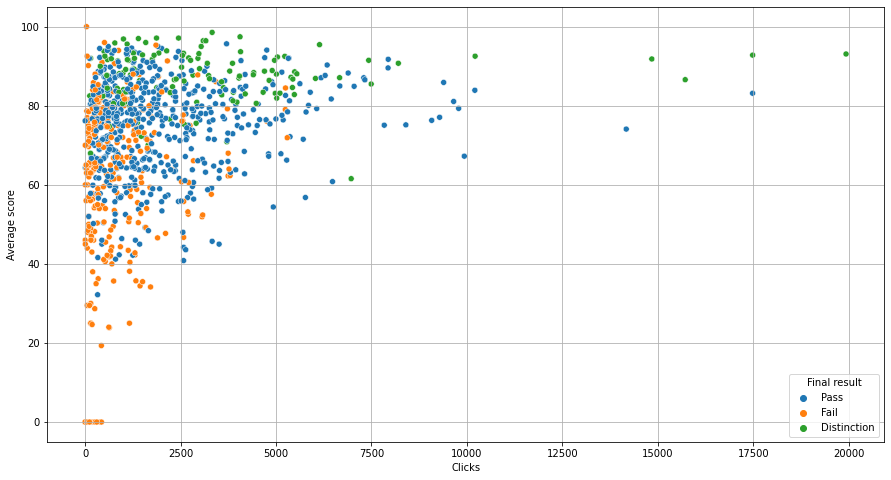

In [17]:
# Merge student_info with student_assessment to get average score
table = pd.merge(student_info, student_assessment, how='left', on=['id_student'])[['id_student', 'score', 'final_result']]
table.fillna(value=0, inplace=True)
table = table.groupby(by=['id_student', 'final_result']).mean().reset_index()

# Merge previous table with student_vle to get total amount of clicks
table = pd.merge(table, student_vle, how='left', on=['id_student'])[['id_student', 'final_result', 'score', 'sum_click']]
table.fillna(value=0, inplace=True)
table = table.groupby(by=['id_student', 'final_result', 'score']).sum().reset_index()

table = table[table['final_result'] != 'Withdrawn']
table.rename(columns={'score': 'Average score', 'final_result': 'Final result', 'sum_click': 'Clicks'}, inplace=True)
table = table.sample(1000)

plt.figure(figsize=(15, 8))
plt.grid()
sns.scatterplot(data=table, x='Clicks', y='Average score', hue='Final result')

**Vrsta istraživanja prema svrsi**: primjenjeno istraživanje

- Želi se otkriti obrazac uspjeha u učenju kako bi se moglo
na vrijeme identificirati oni koji bi mogli imati poteškoće.


**Vrsta istraživanja prema dubini**: istraživačno (explanatory) istraživanje

- Postavlja temeljne okvire i hipoteze o ključnim socio-ekonomskim i demografskim značajkama
koje utječu na uspjeh pojedinca za daljnje, dublje analize.


**Vrsta istraživanja prema vrsti korištenih podataka**: kvantitativno istraživanje

- Podaci su kvantitativni te se koriste statističke metode i metode strojnog učenja kako bi se objasnio i predvidio
uspjeh polaganja tečaja.

**Vrsta istraživanja prema stupnju manipulacije varijablama**: promatračko istraživanje (opservacijsko, deskriptivno, neeksperimentalno)

- Nema intervencije istraživača, već se koriste podaci koji su skupljeni u prirodnom okruženju.

**Vrsta istraživanja prema vrsti zaključka**: hipotetičko-deduktivno istraživanje

- U ovom istraživanju promatra se stvarnost te skupljaju podaci kako bi se postavila hipoteza da socio-ekonomske
i demografske karakteristike pojedicna utječu na njihov uspjeh, zatim se pomoću modela strojnog učenja pokušavaju izoliati
sve one karakteristike pomoću kojih je moguće zaključiti i predivdjeti buduće uspjehe i neuspjehe.

**Vrsta istraživanja prema vremenu provedbe**: studija presjeka ili sinkrono istraživanje

- Promatraju se određeni trenutci u istraživanju, konkretno početak tečaja i kraj tečaja. Nije naglasak na tome kako se
pojedinci ponašaju tijekom tečaja, već što možemo reći o krajnjom rezultatu tečaja (prolaz, pad itd.) na temelju podataka
koje imamo na početku, prije početka tečaja. Ne prate se kako se varijable mijenjaju tijekom tečaja jer većina njih
(socio-ekonomske i demografske) su konzistentne cijelo vrijeme.

**Vrsta istraživanja prema izvoru informacija**: sekundarno istraživanje

- Izvor informacija dolazi iz vanjskih izvora, OULAD (Open University Learning Analytics Dataset) te se želi
identificirati obrasci i trendovi koji upućuju na drugačije ishode završetka tečaja.

**Vrsta istraživanja prema načinu prikupljanja podataka**: dokumentarno istraživanje

- Rad koristi vanjsku bazu podataka koji su drugi istraživači prikupili, a za te istraživače možemo reći da su radili
terensko istraživanje jer su skupljali podatke sa izvora (tečaja).

**Metode prikupljanja podataka**: opservacijsko istraživanje

- Skupljeni podaci su dobiveni opservacijom, tj. promatranju stvari onako kako se događaju, bez ikakve intervencije.
Radi se o sistematskom promatranju gdje se skupljaju kvantitavni objektivni podaci (poput prve ocjene ili broj klikova
prije početka tečaja).

**Istraživačka etika**:

Na [ovoj poveznici](https://www.nature.com/articles/sdata2017171#Sec2) nalazi se kratak osvrt na način prikupljanja podataka.
Najbitnije stvari su citirane u nastavku.

- sudionici su zaštićeni od fizičkih i psihičkih ozlijeda
- sudionici su anonimni (izbačeni su bilo kakve privatne informacije koje bi mogle identificirati studente)
    > The first step removed private information about students and modules.
    > This includes the social security number, dates of birth and unique identifiers used at the OU for students.
    > Module names have been replaced by semantic-free symbols and all temporal information has been expressed in relative terms with respect to the presentation start.
    > In addition, all numeric identifiers (i.e., student_id, code_module, etc.) have been reassigned and completely randomised.
- povjerljivi podaci nisu uključeni u javni dataset

---
Merge Distinction and Pass into Pass category and Fail and Withdrawn into Fail category.

In [23]:
# Pass and Distinction = 1, Fail and Withdrawn = -1
merge_lambda = distinction_lambda = lambda x: 1 if x >= 2 else -1

# X_train and X_test stay the same
y_train_bin = y_train.map(merge_lambda)
y_test_bin = y_test.map(merge_lambda)

-1    5096
 1    4682
Name: final_result, dtype: int64